Challenge Begins
---
<div class="alert alert-block alert-success">
As time flies, Now the time let us attend compettiion:

[Tbrain by Trend-Micro](https://tbrain.trendmicro.com.tw)  台灣 ETF 價格預測競賽

 <div class="alert alert-block alert-warning">
1. Huge data file: the way to read a data file, chunk by chunk,
```python
chunksize = 10 ** 6
for chunk in pd.read_csv(filename, chunksize=chunksize):
       process(chunk)
```    

<div style="font-size:1.4em;">
    
|序號|欄位|說明|
|-:|-:|-:|
|0|ETFid|ETF 代號|
| 1| Mon_ud | 周一漲跌 (1:漲, 0:平, -1:跌) 50% |
| 2| Mon_cprice| 周一收盤價 (權重 50%) |
| 3| Tue_ud | 周二漲跌 (1:漲, 0:平, -1:跌) 50% |
| 4| Tue_cprice| 周二收盤價 (權重 50%) |
| 5| Wed_ud | 周三漲跌 (1:漲, 0:平, -1:跌) 50% |
| 6| Wed_cprice| 周三收盤價 (權重 50%) |
| 7| Thu_ud | 周四漲跌 (1:漲, 0:平, -1:跌) 50% |
| 8| Thu_cprice| 周四收盤價 (權重 50%) |
| 9| Fri_ud | 周五漲跌 (1:漲, 0:平, -1:跌) 50% |
| 10| Fri_cprice| 周五收盤價 (權重 50%) |

</div>
<div class="alert alert-block alert-info">
Sample

```
ETFid,Mon_ud,Mon_cprice,Tue_ud,Tue_cprice,Wed_ud,Wed_cprice,Thu_ud,Thu_cprice,Fri_ud,Fri_cprice
0050,1,87.15,1,88.05,-1,88.00,-1,87.25,1,87.45
...
```

In [1]:
#from hmmlearn.hmm import GaussianHMM
import numpy as np
from matplotlib import cm, pyplot as plt
import matplotlib.dates as dates
import pandas as pd
import datetime

In [2]:
import warnings
warnings.filterwarnings('ignore')


In [3]:
import pandas as pd
import numpy as np

from fbprophet import Prophet
#import pandas_profiling as pp
#from matplotlib import cm, pyplot as plt
import matplotlib.dates as dates
#import pandas_datareader.data as web
from pandas_datareader import data as web
import datetime
#from hmmlearn.hmm import GaussianHMM

import fix_yahoo_finance as yf
yf.pdr_override()

In [5]:
# up to 2018-05-04 and predict 2018-05-07~2018-05-11
# data folder: yahoo/20180504/0050.csv ... 

SaveDirectory = "yahoo/20180504"

Boosting
---

**adaboost**

Initialize a Sequence of categrories of $n$ sample, $M=(M_i)_{i}= (M_1,M_2,\cdots,M_m)$; and improve the accuracy of training based on the previous results.

1. assign weight, $s=(s_i)_n$, for each sample.
- training and calculate accuracy
- evaluate whether each sample is in the right categrory; if not, increate the weight, correct the fault in the next training;
- repeate 2-3 while the $M$ is confirmed;
- normailze sum of accuracies of $M$ being 1, says $(w)=(w_i)$ and get the model as
 $$ M=\sum_{i=1}^m w_iM_i=\mathbf{w\cdot M}$$

In [65]:
df0050_date=pd.read_csv("yahoo/20180504/0050.csv",index_col='Date') 
df0050_date.index=pd.to_datetime(df0050_date.index)

In [42]:
from sklearn.ensemble import AdaBoostRegressor

def adaboost(df,nEstimators=100):
    
    estimator = AdaBoostRegressor(n_estimators=nEstimators)
    X=(df.index - df.index[0]).days.values.reshape(-1, 1)
    Y=df.Close

    # Train the model using the training sets
    estimator.fit(X,Y)
    return estimator

In [66]:
AdaBoostEstimator=adaboost(df0050_date)


In [94]:
X=(df0050_date.index - df0050_date.index[0]).days.values.reshape(-1, 1)
Y=df0050_date.Close

In [95]:
Y_pred_adaboost = AdaBoostEstimator.predict(X)


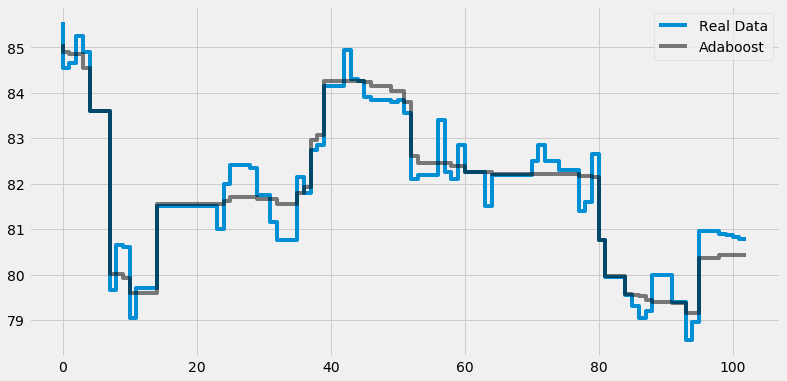

In [96]:
plt.figure(figsize=(12,6))
plt.style.use('fivethirtyeight')
plt.step(X,Y,label='Real Data')
plt.step(X,Y_pred_adaboost,'k--',label='Adaboost',alpha=0.5)

plt.legend()

In [70]:
from sklearn.metrics import mean_squared_error, r2_score

# The coefficients
print('Prediction of AdaBoost')
print("Mean squared error: %.2f"
      % mean_squared_error(Y, Y_pred_adaboost))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y, Y_pred_adaboost))


Prediction of AdaBoost
Mean squared error: 0.18
Variance score: 0.94


Another Boost Model, Gradient-Boosting
---
Not based on correcting previous training, but on the difference between real data and previous prediction.


Decision Tree
---
Decision tree alothim is an efficient way to make a tree-like graphic where we can start at the "root" and traverse our way down by making decisions at the "branches" before finally ending up at a "leaf" that gives you the prediction.

The general steps for building a (regression) decision tree are as follows:

1. At beginning, start with the sample $S$, and Feature set $F={f_1,f_2,\cdots}$.
- entropy of information is defined as follows:
$$ \text{Entropy}= -\sum_i p_i\log_2p_i$$
$$ \text{MSE}=\frac{1}{n}\sqrt{\sum_i^n(\hat {x_i\!}-x_i)^2}$$
- Find the degree of decend for partition Samples with each features and find out which one is fastest, for instance:
$$S=S_1(<f_i)\cup S_2(>f_i)$$

- Remove the feature, $f_i$, and repeate above to prune the stem until no feature exists. 

The implement schemes are in  included in `sklearn.tree.DecisionTreeClassifier` and `sklearn.tree.DecisionTreeRegressor` for supervised and non-supervised training respectively.


However, training accuracy should depend on the chosen *root*. Random Forest Model could be treated as baggage of decision-tree algoritms on randomly chosen sub-samples.


In [49]:
features=['date','Open', 'High', 'Low','Volume', 'weekday', 
             'yesterday_close', 'yesterday_volume', 'price_change',
             'volume_change', 'sign']

In [74]:
X=df_sub.as_matrix()
Y=df0050_date.Close

In [77]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz

def DecisionTree(df,min_samples_split=20, random_state=99,criterion='mse'):
    df_sub=df[features]
    
    estimator = DecisionTreeRegressor(min_samples_split=min_samples_split, random_state=random_state,
                                       criterion=criterion)
    #X=(df.index - df.index[0]).days.values.reshape(-1, 1)
    X=df_sub.as_matrix()
    Y=df.Close

    # Train the model using the training sets
    estimator.fit(X,Y)
    return estimator

In [78]:

DecisionTreestimator=DecisionTree(df0050_date)

Y_pred_DT = DecisionTreestimator.predict(X)

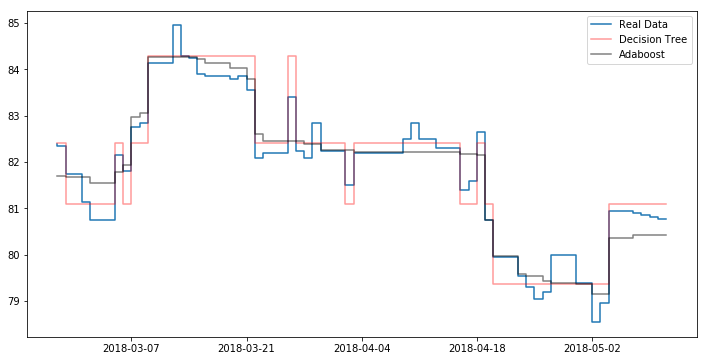

In [80]:
plt.figure(figsize=(12,6))

plt.step(df0050_date.index[-50:],Y[-50:],label='Real Data')
plt.step(df0050_date.index[-50:],Y_pred_DT[-50:],'r--',label='Decision Tree',alpha=0.4)
plt.step(df0050_date.index[-50:],Y_pred_adaboost[-50:],'k--',label='Adaboost',alpha=0.5)

plt.legend()

In [81]:
# The coefficients
print('Prediction of Decision Tree Method')
print("Mean squared error: %.2f"
      % mean_squared_error(Y, Y_pred_DT))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y, Y_pred_DT))


Prediction of Decision Tree Method
Mean squared error: 0.19
Variance score: 0.94


In [82]:
DecisionTreestimator

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=20, min_weight_fraction_leaf=0.0,
           presort=False, random_state=99, splitter='best')

To make visualize the DecisionTree result, install pydotplus by `pip`.

In [83]:
import subprocess

export_graphviz(DecisionTreestimator,out_file="tree.dot",feature_names=features,rotate=True,
                filled=True,rounded=True)
command = ["dot", "-Tpng", "tree.dot", "-o", "3.png"]
subprocess.check_call(command)

0

<img src="3.png" />

In [84]:
from sklearn.ensemble import RandomForestRegressor

def rfc(df,nEstimators=100):
    df_sub=df[features]
    estimator = RandomForestRegressor(n_estimators=nEstimators)
    X=df_sub.as_matrix()
    Y=df.Close

    # Train the model using the training sets
    estimator.fit(X,Y)
    return estimator

In [85]:
rfcEstimator=rfc(df0050_date)
Y_pred_rfc = rfcEstimator.predict(X)

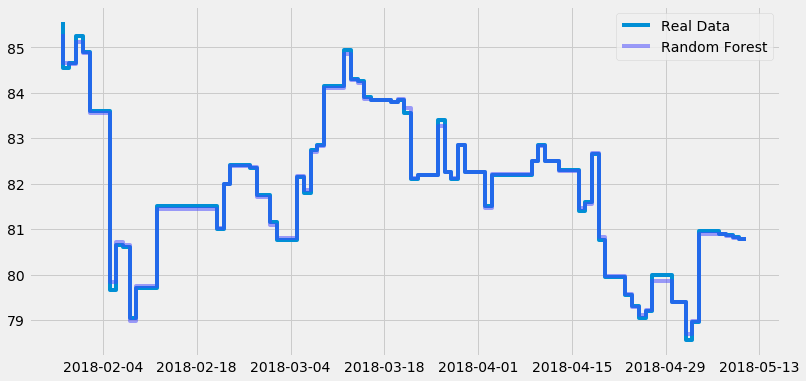

In [91]:
plt.figure(figsize=(12,6))

plt.step(df0050_date.index,Y,label='Real Data')
#plt.step(X,Y_pred_non,'r--',label='Nonlinear Regress',alpha=0.4)
#plt.step(X,Y_pred,'g--',label='Linear Regress',alpha=0.3)
#plt.step(X,Y_pred_adaboost,'k--',label='Adaboost',alpha=0.5)
plt.step(df0050_date.index,Y_pred_rfc,'#4444ff',label='Random Forest',alpha=0.5)
plt.legend()

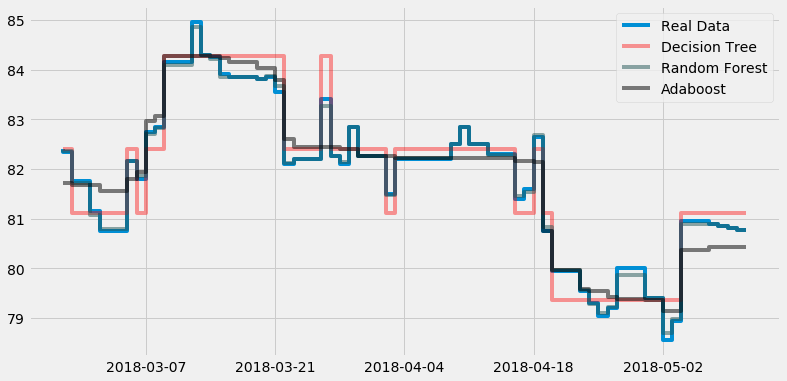

In [92]:
plt.figure(figsize=(12,6))

plt.step(df0050_date.index[-50:],Y[-50:],label='Real Data')
plt.step(df0050_date.index[-50:],Y_pred_DT[-50:],'r--',label='Decision Tree',alpha=0.4)
plt.step(df0050_date.index[-50:],Y_pred_rfc[-50:],'#225555',label='Random Forest',alpha=0.5)
plt.step(df0050_date.index[-50:],Y_pred_adaboost[-50:],'k--',label='Adaboost',alpha=0.5)
plt.legend()

In [87]:
print(' There are %d numbers of DT\'s in Random Forest Method' %len(rfcEstimator.estimators_))

 There are 100 numbers of DT's in Random Forest Method


In [97]:
# The coefficients
print('Prediction of RFC Method')
print("Mean squared error: %.2f"
      % mean_squared_error(Y, Y_pred_rfc))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y, Y_pred_rfc))


Prediction of RFC Method
Mean squared error: 0.00
Variance score: 1.00


**The Board of importance of Features in the Estimator** 

In [88]:
from sklearn.feature_selection import RFE


def feature_selection(estimator, x, y,features=features):
    selector = RFE(estimator)
    selector.fit(x, y)
    print('Importance of Features selection for Random Forest Estimator')
    print(pd.DataFrame(
        {'support': selector.support_, 'ranking': selector.ranking_},
        index=features))


feature_selection(rfcEstimator, X,Y)

Importance of Features selection for Random Forest Estimator
                  ranking  support
Open                    1     True
High                    1     True
Low                     1     True
Close                   1     True
Volume                  4    False
weekday                 1     True
code                    7    False
yesterday_close         2    False
yesterday_volume        1     True
price_change            5    False
volume_Change           3    False
sign                    6    False


In [89]:
# Visualization of Importance
importances = list(rfcEstimator.feature_importances_)

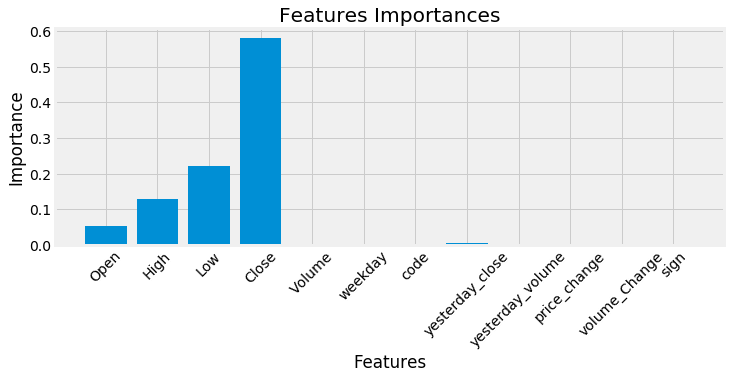

In [90]:
# Set the style
plt.figure(figsize=(12,4))
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_val = list(range(len(importances)))
# Make a bar chart
plt.bar(x_val, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_val, features, rotation=45)
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Features'); plt.title('Features Importances');